In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def plotTimeInterval(data, stations_plot, days_start=1, days_end=30, ylabel="Energy per period (Wh/period)"):

    plt.figure(figsize=(10,4))
    for stat in stations_plot:
        column_name = 'Power_'+stat
        
        start = data.index[0] + pd.DateOffset(days=days_start-1)
        end = start + pd.DateOffset(days=days_end-1)
        plt.plot(data.loc[start:end].index, data.loc[start:end][column_name])
    plt.title(f"Energy supply between day {days_start} and day {days_end}", size = 18)
    plt.ylabel(ylabel, size = 12)
    plt.xlabel("Time", size = 12)
    plt.legend(stations_plot)
    plt.show()

# Francia - París

In [3]:
df = pd.read_csv("transactions-data-April.csv", sep=";")

In [4]:
df = df[['Station','Date de début','Durée (sec)', 'L\'énergie (Wh)']]
df.head()

,Station,Date de début,Durée (sec),L'énergie (Wh)
0,72 RUE DE ROME,Fri Apr 14 2017 00:49:24 GMT+0200 (CEST),21472,13830
1,72 RUE DE ROME,Wed Apr 19 2017 13:51:25 GMT+0200 (CEST),6145,26439
2,72 RUE DE ROME,Sun Apr 09 2017 22:21:30 GMT+0200 (CEST),50819,28072
3,72 RUE DE ROME,Wed Apr 05 2017 19:12:34 GMT+0200 (CEST),12764,4135
4,72 RUE DE ROME,Tue Apr 04 2017 21:59:04 GMT+0200 (CEST),30549,10161


In [5]:
len(df)

3387

In [6]:
from calendar import month_abbr

In [7]:
def toDateTime(s):
    split = s.split(" ")
    month = list(month_abbr).index("Apr")
    formatted = split[4] + " " + split[2] + "-" + f"{month:02}" + "-" + split[3]
    return pd.to_datetime(formatted,format="%H:%M:%S %d-%m-%Y")

In [8]:
def Timestamp2Time(Timestamp):
    return Timestamp.time()

def Timestamp2Date(Timestamp):
    return Timestamp.date()

In [9]:
df["Start"] = df['Date de début'].map(toDateTime)
df["Start_time"] = df['Start'].map(Timestamp2Time)
df["Start_date"] = df['Start'].map(Timestamp2Time)

In [10]:
df = df.drop(columns = ['Date de début'])
df = df.rename(columns={"Durée (sec)": "Duration", "L'énergie (Wh)": "Energy"})
df['Duration'] = df['Duration'].astype(int)

In [11]:
df = df.sort_values(by="Start")

In [12]:
df

,Station,Duration,Energy,Start,Start_time,Start_date
2764,RUE DE TOLBIAC,36,0,2017-04-01 00:08:05,00:08:05,00:08:05
2763,RUE DE TOLBIAC,874,516,2017-04-01 00:09:44,00:09:44,00:09:44
1973,Place Saint Gervais,1956,7167,2017-04-01 00:15:15,00:15:15,00:15:15
3162,RUE LA FAYETTE,191,0,2017-04-01 00:36:24,00:36:24,00:36:24
3163,RUE LA FAYETTE,21951,14231,2017-04-01 00:39:50,00:39:50,00:39:50
...,...,...,...,...,...,...
1917,PLACE DU PANTHEON,3411,8163,2017-04-30 22:09:37,22:09:37,22:09:37
1545,BOULEVARD DE VAUGIRARD,3446,16734,2017-04-30 22:52:36,22:52:36,22:52:36
1469,BOULEVARD DE CLICHY,39,0,2017-04-30 23:46:32,23:46:32,23:46:32
1470,BOULEVARD DE CLICHY,44,0,2017-04-30 23:48:01,23:48:01,23:48:01


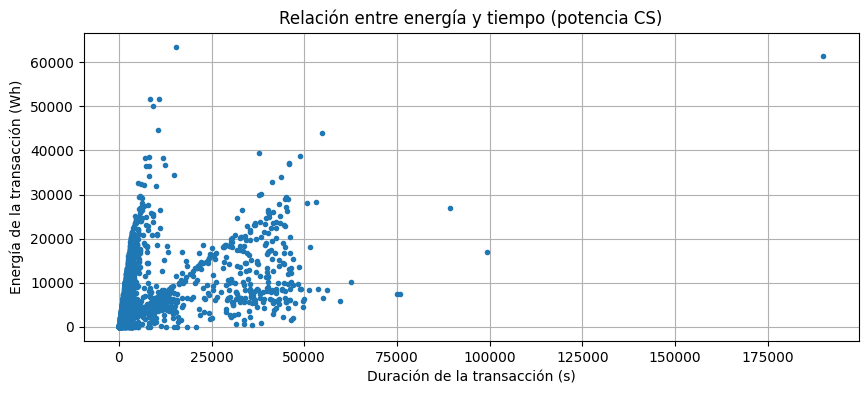

In [13]:
plt.figure(figsize=(10,4))
plt.plot(df['Duration'],df['Energy'],'.')
plt.title("Relación entre energía y tiempo (potencia CS)")
plt.ylabel("Energía de la transacción (Wh)")
plt.xlabel("Duración de la transacción (s)")
plt.grid()
plt.show()

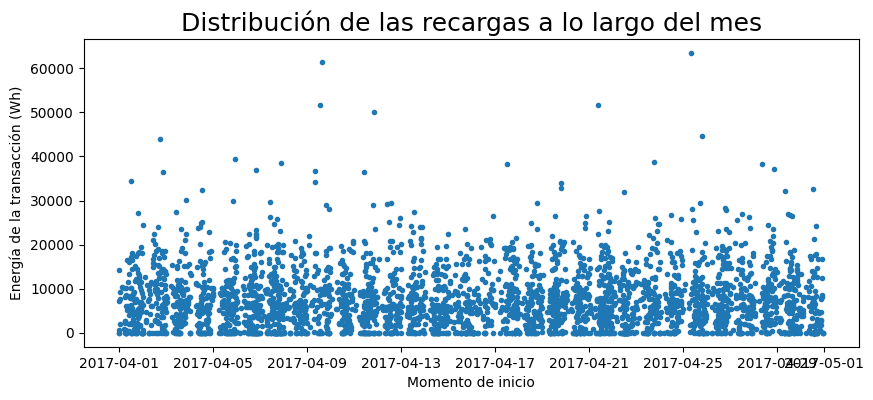

In [14]:
plt.figure(figsize=(10,4))
plt.plot(df['Start'],df['Energy'],'.')

plt.title("Distribución de las recargas a lo largo del mes", size=18)
plt.ylabel("Energía de la transacción (Wh)")
plt.xlabel("Momento de inicio")
plt.show()

In [15]:
import matplotlib.dates

In [16]:
x_values = [(t.hour + t.minute / 60 + t.second / 3600) for t in df['Start_time']]

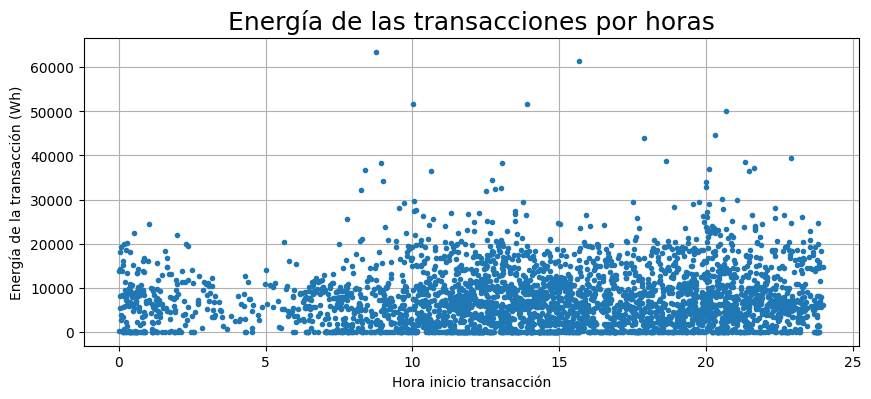

In [17]:
plt.figure(figsize=(10,4))
plt.plot(x_values,df['Energy'],'.')

# Customize the plot
plt.xlabel('Hora inicio transacción')
plt.ylabel('Energía de la transacción (Wh)')
plt.title('Energía de las transacciones por horas', size=18)
plt.grid(True)

# Show the plot
plt.show()

## Conversión a continuo

Convertimos la lista de cargas de vehículos a una lista de la energía entregada por la estación en cada segundo durante todo el més. 
- Para ello hacemos la siguiente suposición: la carga se distribuye uniformemente a lo largo de toda la duración de la transacción, es decir que para cada recarga suponemos una potencia constante igual a la energía total / tiempo de la recarga
- Para refinar este modelo sería necesaria información durante la propia recarga, lo cual de momento no está disponible

### Get the list of stations

In [18]:
stations = df['Station'].unique()
print(f"Number of Stations: {len(stations)}")

Number of Stations: 34


### Calculate power of each transaction

In [19]:
df["Power"] = df["Energy"]/df["Duration"] # Wh/s

### Row for each second

In [20]:
# Creamos una serie con todos los instantes de tiempo (cada segundo) de todo el mes
start = df['Start'].iloc[0]
end = df['Start'].iloc[-1]
all_secs = pd.period_range(start=start, end=end, freq='s').to_timestamp()

In [21]:
# Creamos el dataset con la potencia de la estación en cada momento del tiempo
df_cont = pd.DataFrame(index=all_secs)

# Por cada estación
for stat in stations:
    print(stat)
    new_column_name = 'Power_' +stat 
    df_cont[new_column_name] = 0
    
    # Llenamos el dataset con la información de las recargas
    for charge in df[df['Station']==stat].itertuples():
        start = charge.Start
        end = start + pd.DateOffset(seconds=charge.Duration)
        
        df_cont.loc[start:end, new_column_name] += charge.Power

RUE DE TOLBIAC
Place Saint Gervais
RUE LA FAYETTE
PLACE DU PANTHEON
AVENUE DE LA GRANDE ARMEE
AVENUE DE LA PORTE DE VILLIERS
RUE CHANGARNIER
AVENUE REILLE
RUE DIDOT
RUE VILLIOT
BOULEVARD MASSENA
AVENUE PAUL DOUMER
AVENUE DE FLANDRE
AVENUE PARMENTIER
RUE LECOURBE
RUE CHARDON LAGACHE
AVENUE GOURGAUD
RUE DE REAUMUR
RUE ETIENNE MARCEL
RUE ABEL
AVENUE DU PÈRE LACHAISE
BD VOLTAIRE
72 RUE DE ROME
AV DUTUIT
RUE DE COURCELLES
RUE CAULAINCOURT
AVENUE VICTOR HUGO
81 RUE DE ROME
RUE LOUIS MURAT
BOULEVARD DE CLICHY
RUE DESNOUETTES
BOULEVARD DE VAUGIRARD
AVENU DES TERNES
PLACE ARMAND CARREL


### Visualize continious data

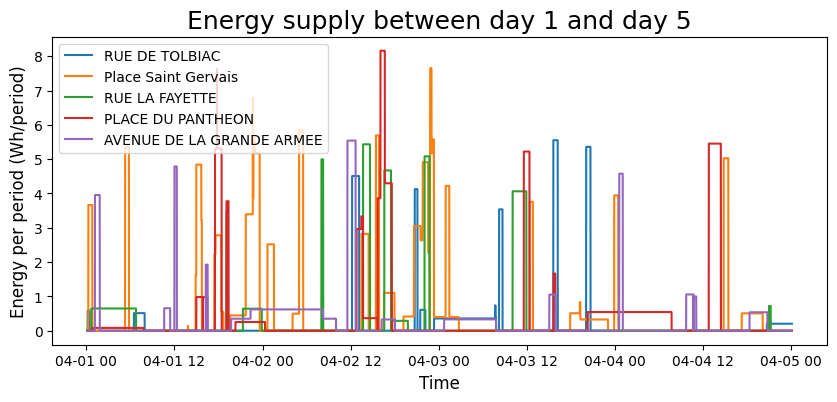

In [22]:
plotTimeInterval(df_cont, stations[0:5], days_start=1, days_end=5)

# EEUU - Colorado

## Tratamiento de datos

In [23]:
Colorado_data = pd.read_csv("Electric_Vehicle_Charging_Station_Data.csv", sep=",")
Colorado_data.columns

Index(['ObjectId2', 'Station_Name', 'Address', 'City', 'State_Province',
       'Zip_Postal_Code', 'Start_Date___Time', 'Start_Time_Zone',
       'End_Date___Time', 'End_Time_Zone', 'Total_Duration__hh_mm_ss_',
       'Charging_Time__hh_mm_ss_', 'Energy__kWh_', 'GHG_Savings__kg_',
       'Gasoline_Savings__gallons_', 'Port_Type', 'ObjectID'],
      dtype='object')

In [24]:
# Seleccionamos solo algunas columnas
Colorado_data = Colorado_data[['Station_Name','Start_Date___Time','Charging_Time__hh_mm_ss_','Energy__kWh_']]
Colorado_data = Colorado_data.rename(columns={"Station_Name": "Station", "Start_Date___Time": "Start",
                                              "Energy__kWh_": "Energy", "Charging_Time__hh_mm_ss_": "Duration"})
Colorado_data.head()

,Station,Start,Duration,Energy
0,BOULDER / JUNCTION ST1,1/1/2018 17:49,2:02:44,6.504
1,BOULDER / JUNCTION ST1,1/2/2018 8:52,0:24:19,2.481
2,BOULDER / JUNCTION ST1,1/2/2018 21:11,3:40:52,15.046
3,BOULDER / ALPINE ST1,1/3/2018 9:19,1:54:29,6.947
4,BOULDER / BASELINE ST1,1/3/2018 14:13,0:16:44,1.800


In [25]:
# Número de recargas
len(Colorado_data)

70194

In [26]:
# Número de estaciones
len(Colorado_data.Station.unique())

40

### Conversion de variables

In [27]:
# Convertimos fecha de inicio en Timestamp
# Utilizar format="mixed" es peligroso, pero aquí lo hacemos porque la tabla mezcla varios formatos
# Hemos comprobado y en principio lo ha hecho bien 
Colorado_data['Start'] = pd.to_datetime(Colorado_data['Start'], format="mixed")  #primer formato: "%m/%d/%Y %H:%M"

In [28]:
# Pasamos de %H:%M:%S a segundos
Colorado_data['Duration'] = pd.to_timedelta(Colorado_data['Duration']).dt.total_seconds()

In [29]:
# Pasamos de kWh a Wh por consistencia
Colorado_data['Energy'] *= 1000

In [30]:
Colorado_data.head()

,Station,Start,Duration,Energy
0,BOULDER / JUNCTION ST1,2018-01-01 17:49:00,7364.0,6504.0
1,BOULDER / JUNCTION ST1,2018-01-02 08:52:00,1459.0,2481.0
2,BOULDER / JUNCTION ST1,2018-01-02 21:11:00,13252.0,15046.0
3,BOULDER / ALPINE ST1,2018-01-03 09:19:00,6869.0,6947.0
4,BOULDER / BASELINE ST1,2018-01-03 14:13:00,1004.0,1800.0


## Visualización de datos

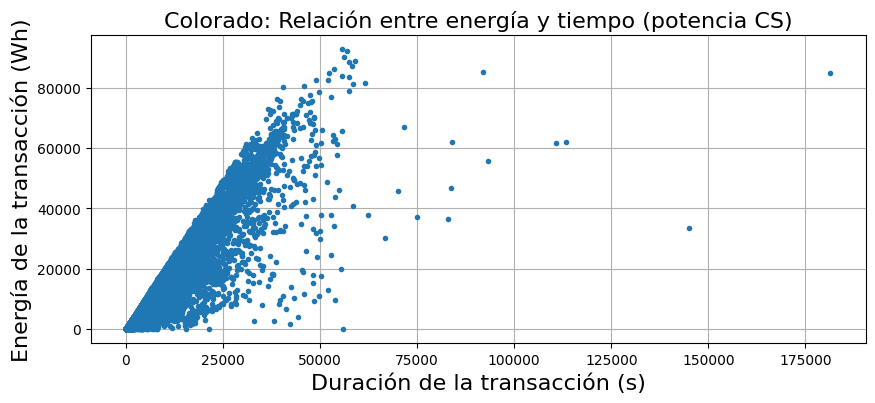

In [31]:
plt.figure(figsize=(10,4))
plt.plot(Colorado_data['Duration'],Colorado_data['Energy'],'.')
plt.title("Colorado: Relación entre energía y tiempo (potencia CS)", size = 16)
plt.ylabel("Energía de la transacción (Wh)", size = 16)
plt.xlabel("Duración de la transacción (s)", size = 16)
plt.grid()
plt.show()

Se ve claramente cual es la potencia máxima de las electrolineras

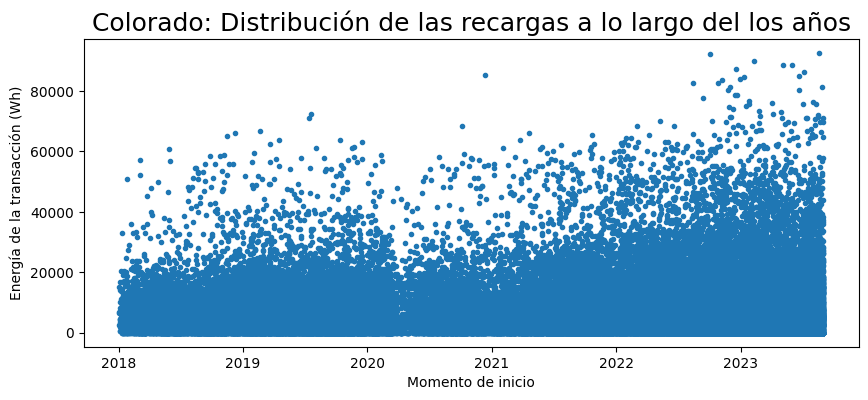

In [32]:
plt.figure(figsize=(10,4))
plt.plot(Colorado_data['Start'],Colorado_data['Energy'],'.')

plt.title("Colorado: Distribución de las recargas a lo largo del los años", size=18)
plt.ylabel("Energía de la transacción (Wh)")
plt.xlabel("Momento de inicio")
plt.show()

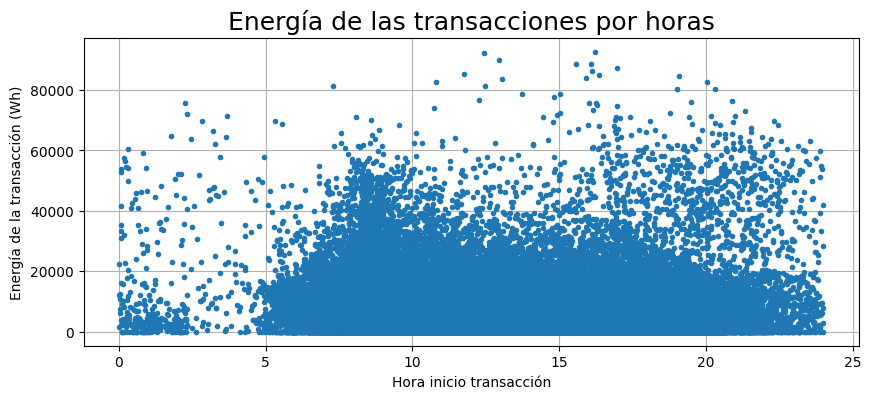

In [33]:
Colorado_x_values = [(t.hour + t.minute / 60 + t.second / 3600) for t in Colorado_data['Start']]

plt.figure(figsize=(10,4))
plt.plot(Colorado_x_values,Colorado_data['Energy'],'.')

# Customize the plot
plt.xlabel('Hora inicio transacción')
plt.ylabel('Energía de la transacción (Wh)')
plt.title('Energía de las transacciones por horas', size=18)
plt.grid(True)

# Show the plot
plt.show()

## Conversión a continuo

### Get the list of stations

In [34]:
Colorado_stations = Colorado_data['Station'].unique()
print(f"Number of Stations: {len(Colorado_stations)}")

Number of Stations: 40


### Calculate power of each transaction

In [35]:
Colorado_data["Power"] = Colorado_data["Energy"]/Colorado_data["Duration"] # Wh/s

### Row for each second

In [36]:
# Creamos una serie con todos los instantes de tiempo (cada segundo) de todo el mes
start = Colorado_data['Start'].iloc[0]
end = Colorado_data['Start'].iloc[-1]
Colorado_all_secs = pd.period_range(start=start, end=end, freq='s').to_timestamp()

In [37]:
# Creamos el dataset con la potencia de la estación en cada momento del tiempo
Colorado_cont = pd.DataFrame(index=Colorado_all_secs)

# Por cada estación
for stat in Colorado_stations:
    print(stat)
    new_column_name = 'Power_' +stat 
    Colorado_cont[new_column_name] = 0
    
    # Llenamos el dataset con la información de las recargas
    for charge in Colorado_data[Colorado_data['Station']==stat].itertuples():
        start = charge.Start
        end = start + pd.DateOffset(seconds=charge.Duration)
        
        Colorado_cont.loc[start:end, new_column_name] += charge.Power

BOULDER / JUNCTION ST1
BOULDER / ALPINE ST1
BOULDER / BASELINE ST1
BOULDER / FACILITIES ST1
COMM VITALITY / 1500PEARL2
BOULDER / ATRIUM ST1
BOULDER / REC CENTER ST1
BOULDER / REC CENTER ST2
COMM VITALITY / 1500PEARL1
COMM VITALITY / 1104 SPRUCE1
COMM VITALITY / 1000WALNUT2
COMM VITALITY / 1000WALNUT1
COMM VITALITY / 1400 WALNUT1
COMM VITALITY / BOULDER JCTN
COMM VITALITY / 1100WALNUT1
BOULDER / ANNEX ST1
BOULDER / N BOULDER REC 1
BOULDER / BOULDER PARK S2
BOULDER / BOULDER PARK S1
COMM VITALITY / 2200 BROADWAY1
BOULDER / EAST REC
BOULDERJUNCTION / JUNCTION ST1
BOULDER / RESERVOIR ST1
BOULDER / RESERVOIR ST2
BOULDER / CARPENTER PARK1
BOULDER / CARPENTER PARK2
BOULDER / AIRPORT ST1
COMM VITALITY / 5050 PEARL 1
BOULDER / VALMONT ST2
BOULDER / VALMONT ST1
BOULDER / OSMP FLEET 2
BOULDER / OSMP FLEET 1
MUNICIPAL SC / 1500PEARL2
MUNICIPAL SC / 1104 SPRUCE1
MUNICIPAL SC / 1000WALNUT1
MUNICIPAL SC / 1100WALNUT1
MUNICIPAL SC / 1000WALNUT2
MUNICIPAL SC / 1400 WALNUT1
MUNICIPAL SC / 2200 BROADWAY1

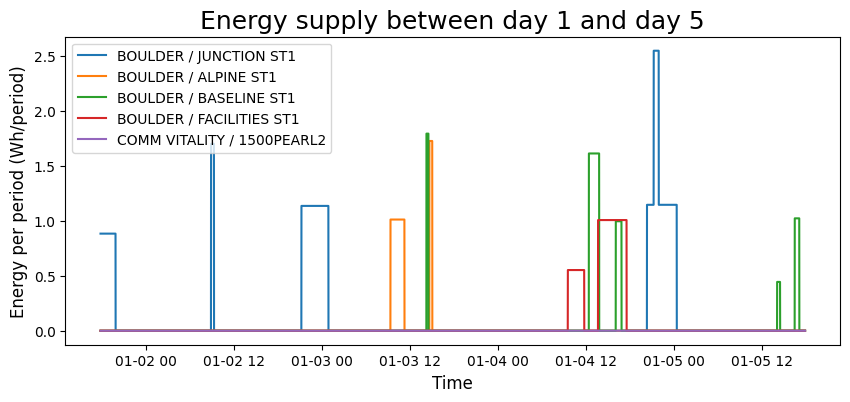

In [38]:
plotTimeInterval(Colorado_cont, Colorado_stations[0:5], days_start=1, days_end=5)

# Barcelona

## Tratamiento de datos

In [4]:
# Seleccionamos HISTORIC DATA 2019 ELECTROLINERES AMB.csv porque Charge2019_EV_AMB.csv no tiene la hora
Bcn_data = pd.read_csv("HISTORIC DATA 2019 ELECTROLINERES AMB.csv", encoding='latin-1',sep=";")
Bcn_data.columns

Index(['CHARGING POINT', 'CONNECTOR', 'START TIME', 'STOP TIME',
       'DURATION (min)', 'CONSUMPTION (kWh)', 'VEHICLE', 'MODEL'],
      dtype='object')

In [5]:
# Número de datos
print(f"Número de cargas (antes de limpiar): {len(Bcn_data)}")

# Número de electrolineras
print(f"Número de electrolineras: {len(Bcn_data['CHARGING POINT'].unique())}")

Número de cargas (antes de limpiar): 38219
Número de electrolineras: 21


*IMPORTANTE:* La longitud del dataset Charge2019_EV_AMB es de 36413 recargas, no 38219, ya que ha eliminado los registros con energía de carga 0. La columna ID a veces se salta algunos números, de ahí la confusión.

La longitud del dataset de HISTORIC DATA 2019 ELECTROLINERES AMB sí que es 38219, porque incluye también los registros con 0.

In [6]:
# Seleccionamos solo algunas columnas
Bcn_data = Bcn_data[['CHARGING POINT','START TIME','DURATION (min)','CONSUMPTION (kWh)']]
Bcn_data = Bcn_data.rename(columns={"CHARGING POINT": "Station", "START TIME": "Start",
                                              "CONSUMPTION (kWh)": "Energy (kWh)", "DURATION (min)": "Duration (min)"})
Bcn_data.head()

,Station,Start,Duration (min),Energy (kWh)
0,PdRL L'Hospitalet de Ll.: C. Salvador Espriu -...,28/07/2019 11.25,15695,0.0
1,PdRL L'Hospitalet de Ll.: C. Salvador Espriu -...,21/07/2019 11.54,4052,0.0
2,PdRR Badalona: C. Anna Tugas - Pg. Olof Palmer,17/10/2019 09.08,1306,0.0
3,PdRR Sant Joan Despi: C. TV3 - C. Jacint Verda...,29/09/2019 22.15,772,0.0
4,PdRR Pallejà: Rda. Santa Eulalia - C. Joan Mar...,16/05/2019 20.32,679,0.0


#### Limpieza de 0s

In [7]:
# Eliminamos los 0s
Bcn_data = Bcn_data[Bcn_data['Energy (kWh)'] != 0]
Bcn_data.head()

,Station,Start,Duration (min),Energy (kWh)
1806,FLNR Sant Andreu da la Barca: Pg. Rafael de Ca...,18/09/2019 17.05,143,0.008
1807,FLNR Sant Andreu da la Barca: Pg. Rafael de Ca...,08/05/2019 16.07,14,0.009
1808,PdRL Sant Joan Despí: C. TV3 - C. Jacint Verda...,12/11/2019 08.14,237,0.010
1809,PdRL Sant Joan Despí: C. TV3 - C. Jacint Verda...,04/11/2019 10.54,220,0.010
1810,"PdRL Gavà: C. del Progres, 54",15/03/2019 17.22,180,0.010


In [8]:
# Número de datos
print(f"Número de cargas (después de limpiar): {len(Bcn_data)}")

# Número de electrolineras
print(f"Número de electrolineras: {len(Bcn_data['Station'].unique())}")

Número de cargas (después de limpiar): 36413
Número de electrolineras: 21


### Conversion de variables

In [9]:
# Convertimos fecha de inicio en Timestamp
# Utilizar format="mixed" es peligroso, pero aquí lo hacemos porque la tabla mezcla varios formatos
# Hemos comprobado y en principio lo ha hecho bien 
Bcn_data['Start'] = pd.to_datetime(Bcn_data['Start'], format="%d/%m/%Y %H.%M")  

In [10]:
# Pasamos de %H:%M:%S a segundos
Bcn_data['Duration'] = Bcn_data['Duration (min)'] * 60
Bcn_data = Bcn_data.drop(columns=["Duration (min)"])

In [11]:
# Pasamos de kWh a Wh por consistencia
Bcn_data['Energy'] = Bcn_data['Energy (kWh)'] * 1000
Bcn_data = Bcn_data.drop(columns=["Energy (kWh)"])

In [12]:
Bcn_data.head()

,Station,Start,Duration,Energy
1806,FLNR Sant Andreu da la Barca: Pg. Rafael de Ca...,2019-09-18 17:05:00,8580,8.0
1807,FLNR Sant Andreu da la Barca: Pg. Rafael de Ca...,2019-05-08 16:07:00,840,9.0
1808,PdRL Sant Joan Despí: C. TV3 - C. Jacint Verda...,2019-11-12 08:14:00,14220,10.0
1809,PdRL Sant Joan Despí: C. TV3 - C. Jacint Verda...,2019-11-04 10:54:00,13200,10.0
1810,"PdRL Gavà: C. del Progres, 54",2019-03-15 17:22:00,10800,10.0


#### Ordenar datos por fecha
IMPORTANTE: reordenamos los índices!

In [13]:
Bcn_data = Bcn_data.sort_values(by="Start").reset_index(drop=True)

## Visualización de datos

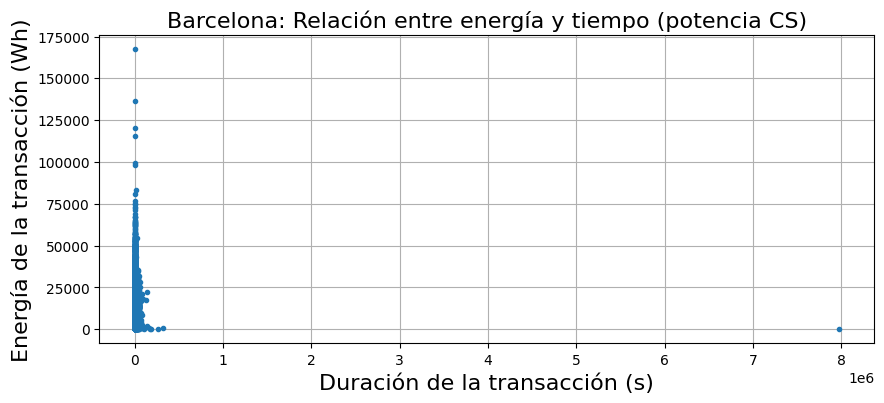

In [14]:
plt.figure(figsize=(10,4))
plt.plot(Bcn_data['Duration'],Bcn_data['Energy'],'.')
plt.title("Barcelona: Relación entre energía y tiempo (potencia CS)", size = 16)
plt.ylabel("Energía de la transacción (Wh)", size = 16)
plt.xlabel("Duración de la transacción (s)", size = 16)
plt.grid()
plt.show()

### Limpieza de outliers

In [15]:
Bcn_data = Bcn_data[Bcn_data['Duration'] < 1.5e5]

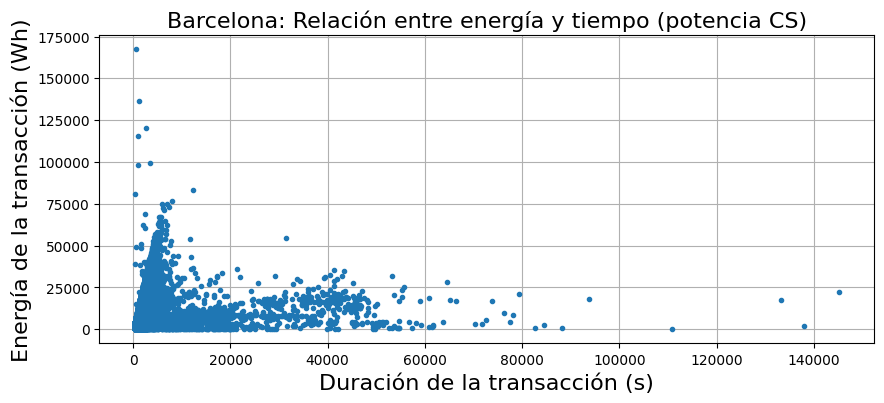

In [16]:
plt.figure(figsize=(10,4))
plt.plot(Bcn_data['Duration'],Bcn_data['Energy'],'.')
plt.title("Barcelona: Relación entre energía y tiempo (potencia CS)", size = 16)
plt.ylabel("Energía de la transacción (Wh)", size = 16)
plt.xlabel("Duración de la transacción (s)", size = 16)
plt.grid()
plt.show()

### Distribución en el tiempo

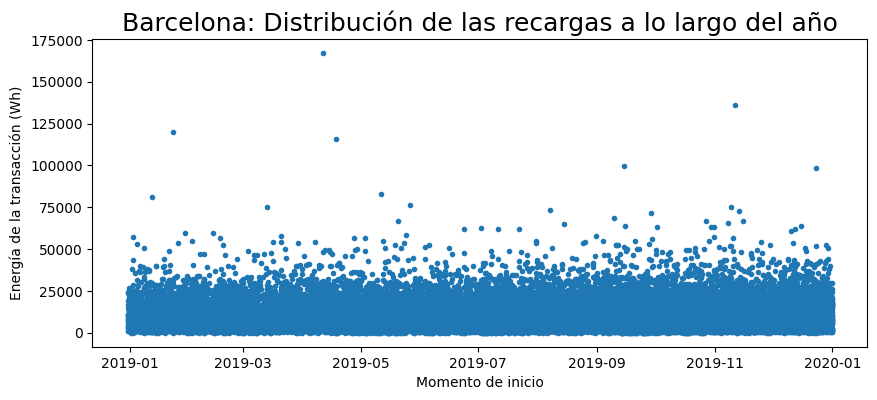

In [17]:
plt.figure(figsize=(10,4))
plt.plot(Bcn_data['Start'],Bcn_data['Energy'],'.')

plt.title("Barcelona: Distribución de las recargas a lo largo del año", size=18)
plt.ylabel("Energía de la transacción (Wh)")
plt.xlabel("Momento de inicio")
plt.show()

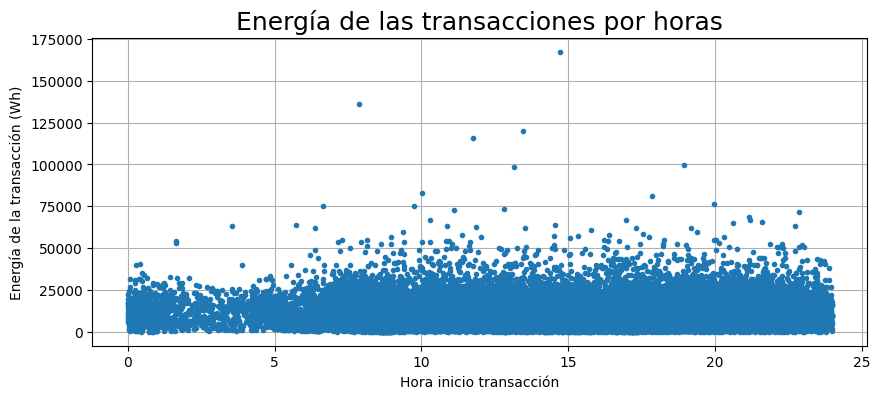

In [18]:
Bcn_start_hours = [(t.hour + t.minute / 60 + t.second / 3600) for t in Bcn_data['Start']]

plt.figure(figsize=(10,4))
plt.plot(Bcn_start_hours,Bcn_data['Energy'],'.')

# Customize the plot
plt.xlabel('Hora inicio transacción')
plt.ylabel('Energía de la transacción (Wh)')
plt.title('Energía de las transacciones por horas', size=18)
plt.grid(True)

# Show the plot
plt.show()

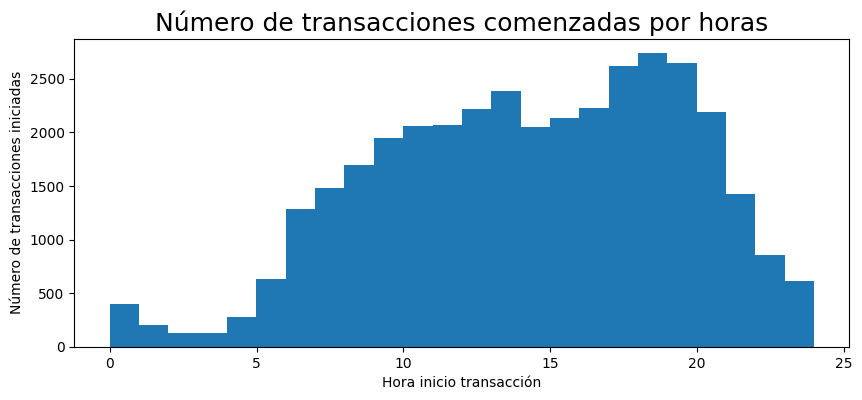

In [19]:
plt.figure(figsize=(10,4))
plt.hist(Bcn_start_hours, bins=24)

# Customize the plot
plt.xlabel('Hora inicio transacción')
plt.ylabel('Número de transacciones iniciadas')
plt.title('Número de transacciones comenzadas por horas', size=18)

# Show the plot
plt.show()

### Get the list of stations

In [20]:
Bcn_stations = Bcn_data['Station'].unique()
print(f"Number of Stations: {len(Bcn_stations)}")

Number of Stations: 21


### Calculate power of each transaction

In [21]:
Bcn_data["Power"] = round(Bcn_data["Energy"]/Bcn_data["Duration"], 2) # Wh/s

### Row for each second

In [22]:
# Creamos una serie con todos los instantes de tiempo (cada segundo) de todo el mes
start = Bcn_data['Start'].iloc[0]
end = Bcn_data['Start'].iloc[-1]
Bcn_all_secs = pd.period_range(start=start, end=end, freq='s').to_timestamp()
start, end

(Timestamp('2018-12-31 00:35:00'), Timestamp('2019-12-31 22:58:00'))

In [23]:
# Creamos el dataset con la potencia de la estación en cada momento del tiempo
Bcn_cont = pd.DataFrame(index=Bcn_all_secs)

# Por cada estación
for stat in Bcn_stations:
    print(stat)
    new_column_name = 'Power_' +stat 
    Bcn_cont[new_column_name] = 0
    
    # Llenamos el dataset con la información de las recargas
    for charge in Bcn_data[Bcn_data['Station']==stat].itertuples():
        start = charge.Start
        end = start + pd.DateOffset(seconds=charge.Duration)
        
        Bcn_cont.loc[start:end, new_column_name] += charge.Power

PdRR Gavà: C. del Progres, 54
PdRR Sant Cugat del Vallès: Av. Via Augusta, 3
PdRR Sant Joan Despi: C. TV3 - C. Jacint Verdaguer
PdRR El Prat de Llobregat: Pl. Volateria (Mas Blau)
PdRR Pallejà: Rda. Santa Eulalia - C. Joan Maragall
PdRR Barberà del Vallés: C. Arquímedes, 8
PdRR l'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes
PdRL Sant Joan Despí: C. TV3 - C. Jacint Verdaguer
PdRR Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer
PdRR Badalona: C. Anna Tugas - Pg. Olof Palmer
PdRL Pallejà: Rda. Santa Eulalia - C. Joan Maragall
PdRL Badalona: C. Anna Tugas - Pg. Olof Palmer
PdRR Montcada i Reixac: C. Tarragona - C. Pla de Matabous
PdRL Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer
PdRL Gavà: C. del Progres, 54
PdRL Montcada i Reixac: C. Tarragona - C. Pla de Matabous
PdRL L'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes
PdRL Sant Cugat del Vallès: Av. Via Augusta, 3
PdRL El Prat de Llobregat: Pl. Volateria (Mas Blau)
Pd

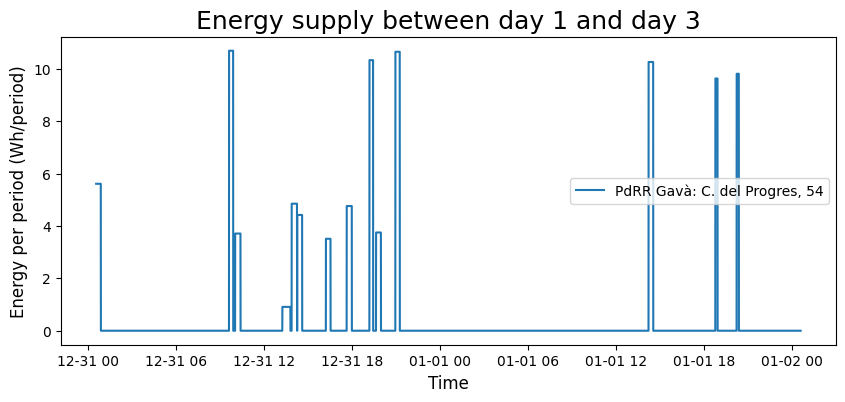

In [24]:
plotTimeInterval(Bcn_cont, Bcn_stations[0:1], days_start=1, days_end=3)

In [25]:
#Bcn_cont.to_csv("Bcn_continuo.csv")

## Agrupamos por intervalos de 15 min

In [26]:
# Agrupación
period_mins = 15
Bcn_15min = Bcn_cont.groupby(pd.Grouper(freq=str(period_mins)+'Min')).sum()

In [27]:
Bcn_15min.head(3)

,"Power_PdRR Gavà: C. del Progres, 54","Power_PdRR Sant Cugat del Vallès: Av. Via Augusta, 3",Power_PdRR Sant Joan Despi: C. TV3 - C. Jacint Verdaguer,Power_PdRR El Prat de Llobregat: Pl. Volateria (Mas Blau),Power_PdRR Pallejà: Rda. Santa Eulalia - C. Joan Maragall,"Power_PdRR Barberà del Vallés: C. Arquímedes, 8",Power_PdRR l'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes,Power_PdRL Sant Joan Despí: C. TV3 - C. Jacint Verdaguer,Power_PdRR Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer,Power_PdRR Badalona: C. Anna Tugas - Pg. Olof Palmer,...,Power_PdRL Badalona: C. Anna Tugas - Pg. Olof Palmer,Power_PdRR Montcada i Reixac: C. Tarragona - C. Pla de Matabous,Power_PdRL Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer,"Power_PdRL Gavà: C. del Progres, 54",Power_PdRL Montcada i Reixac: C. Tarragona - C. Pla de Matabous,Power_PdRL L'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes,"Power_PdRL Sant Cugat del Vallès: Av. Via Augusta, 3",Power_PdRL El Prat de Llobregat: Pl. Volateria (Mas Blau),"Power_PdRL Barberà del Vallés: C. Arquímedes, 8",Power_FLNR Sant Andreu da la Barca: Pg. Rafael de Casanova FGC
2018-12-31 00:30:00,3366.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31 00:45:00,3035.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31 01:00:00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Comprobación de que se ha hecho bien la agrupación
prueba_col = 'Power_'+Bcn_stations[0]
print(f"Suma en el dataset por sec: {sum(Bcn_cont[prueba_col])}, suma en el dataset por periodos: {sum(Bcn_15min[prueba_col])}")
print(f"Tamaño del dataset por sec: {len(Bcn_cont)}, dividido entre {period_mins*60} debería dar: {len(Bcn_cont)/(period_mins*60)}")
print(f"Tamaño del dataset por periodo: {len(Bcn_15min)}")

Suma en el dataset por sec: 53960666.079915926, suma en el dataset por periodos: 53960666.07999986
Tamaño del dataset por sec: 31616581, dividido entre 900 debería dar: 35129.53444444444
Tamaño del dataset por periodo: 35130


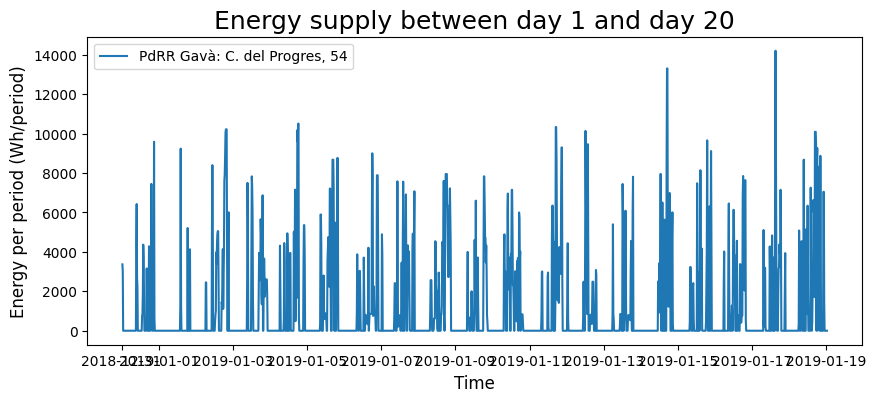

In [73]:
plotTimeInterval(Bcn_15min, Bcn_stations[0:1], days_start=1, days_end=20)

## Guardamos dataset agrupado
Volvemos a poner el tiempo como columna para que sea más facilmente legible

In [30]:
# Modificar para guardar
Bcn_15min_tosave = Bcn_15min.reset_index(inplace=False, names=['Time'])
Bcn_15min_tosave.head(3)

,Time,"Power_PdRR Gavà: C. del Progres, 54","Power_PdRR Sant Cugat del Vallès: Av. Via Augusta, 3",Power_PdRR Sant Joan Despi: C. TV3 - C. Jacint Verdaguer,Power_PdRR El Prat de Llobregat: Pl. Volateria (Mas Blau),Power_PdRR Pallejà: Rda. Santa Eulalia - C. Joan Maragall,"Power_PdRR Barberà del Vallés: C. Arquímedes, 8",Power_PdRR l'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes,Power_PdRL Sant Joan Despí: C. TV3 - C. Jacint Verdaguer,Power_PdRR Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer,...,Power_PdRL Badalona: C. Anna Tugas - Pg. Olof Palmer,Power_PdRR Montcada i Reixac: C. Tarragona - C. Pla de Matabous,Power_PdRL Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer,"Power_PdRL Gavà: C. del Progres, 54",Power_PdRL Montcada i Reixac: C. Tarragona - C. Pla de Matabous,Power_PdRL L'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes,"Power_PdRL Sant Cugat del Vallès: Av. Via Augusta, 3",Power_PdRL El Prat de Llobregat: Pl. Volateria (Mas Blau),"Power_PdRL Barberà del Vallés: C. Arquímedes, 8",Power_FLNR Sant Andreu da la Barca: Pg. Rafael de Casanova FGC
0,2018-12-31 00:30:00,3366.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-12-31 00:45:00,3035.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-12-31 01:00:00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
Bcn_15min_tosave.to_csv("Bcn_15min.csv", index=False)

## Agrupamos por intervalos de 1h

In [32]:
# Agrupación
period_mins = 60
Bcn_1h = Bcn_cont.groupby(pd.Grouper(freq=str(period_mins)+'Min')).sum()

In [33]:
Bcn_1h.head(3)

,"Power_PdRR Gavà: C. del Progres, 54","Power_PdRR Sant Cugat del Vallès: Av. Via Augusta, 3",Power_PdRR Sant Joan Despi: C. TV3 - C. Jacint Verdaguer,Power_PdRR El Prat de Llobregat: Pl. Volateria (Mas Blau),Power_PdRR Pallejà: Rda. Santa Eulalia - C. Joan Maragall,"Power_PdRR Barberà del Vallés: C. Arquímedes, 8",Power_PdRR l'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes,Power_PdRL Sant Joan Despí: C. TV3 - C. Jacint Verdaguer,Power_PdRR Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer,Power_PdRR Badalona: C. Anna Tugas - Pg. Olof Palmer,...,Power_PdRL Badalona: C. Anna Tugas - Pg. Olof Palmer,Power_PdRR Montcada i Reixac: C. Tarragona - C. Pla de Matabous,Power_PdRL Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer,"Power_PdRL Gavà: C. del Progres, 54",Power_PdRL Montcada i Reixac: C. Tarragona - C. Pla de Matabous,Power_PdRL L'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes,"Power_PdRL Sant Cugat del Vallès: Av. Via Augusta, 3",Power_PdRL El Prat de Llobregat: Pl. Volateria (Mas Blau),"Power_PdRL Barberà del Vallés: C. Arquímedes, 8",Power_FLNR Sant Andreu da la Barca: Pg. Rafael de Casanova FGC
2018-12-31 00:00:00,6401.01,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31 01:00:00,0.00,10507.32,12573.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31 02:00:00,0.00,0.00,1942.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# Comprobación de que se ha hecho bien la agrupación
prueba_col = 'Power_'+Bcn_stations[0]
print(f"Suma en el dataset por sec: {sum(Bcn_cont[prueba_col])}, suma en el dataset por periodos: {sum(Bcn_1h[prueba_col])}")
print(f"Tamaño del dataset por sec: {len(Bcn_cont)}, dividido entre {period_mins*60} debería dar: {len(Bcn_cont)/(period_mins*60)}")
print(f"Tamaño del dataset por periodo: {len(Bcn_1h)}")

Suma en el dataset por sec: 53960666.079915926, suma en el dataset por periodos: 53960666.08000002
Tamaño del dataset por sec: 31616581, dividido entre 3600 debería dar: 8782.38361111111
Tamaño del dataset por periodo: 8783


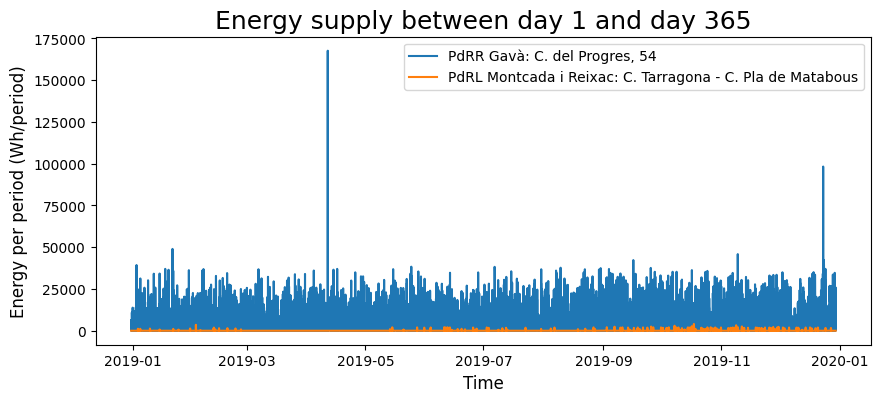

In [35]:
plotTimeInterval(Bcn_1h, Bcn_stations[[0,15]], days_start=1, days_end=365)

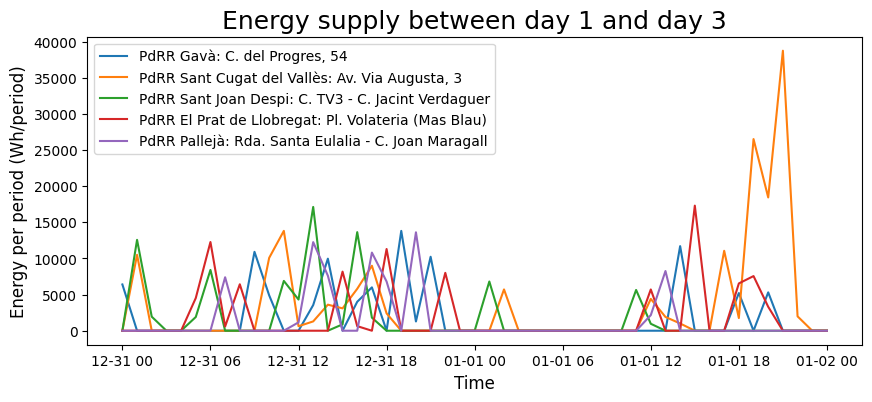

In [36]:
plotTimeInterval(Bcn_1h, Bcn_stations[0:5], days_start=1, days_end=3)

## Guardamos dataset agrupado
Volvemos a poner el tiempo como columna para que sea más facilmente legible

In [37]:
# Modificar para guardar
Bcn_1h_tosave = Bcn_1h.reset_index(inplace=False, names=['Time'])
Bcn_1h_tosave.head(3)

,Time,"Power_PdRR Gavà: C. del Progres, 54","Power_PdRR Sant Cugat del Vallès: Av. Via Augusta, 3",Power_PdRR Sant Joan Despi: C. TV3 - C. Jacint Verdaguer,Power_PdRR El Prat de Llobregat: Pl. Volateria (Mas Blau),Power_PdRR Pallejà: Rda. Santa Eulalia - C. Joan Maragall,"Power_PdRR Barberà del Vallés: C. Arquímedes, 8",Power_PdRR l'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes,Power_PdRL Sant Joan Despí: C. TV3 - C. Jacint Verdaguer,Power_PdRR Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer,...,Power_PdRL Badalona: C. Anna Tugas - Pg. Olof Palmer,Power_PdRR Montcada i Reixac: C. Tarragona - C. Pla de Matabous,Power_PdRL Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer,"Power_PdRL Gavà: C. del Progres, 54",Power_PdRL Montcada i Reixac: C. Tarragona - C. Pla de Matabous,Power_PdRL L'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes,"Power_PdRL Sant Cugat del Vallès: Av. Via Augusta, 3",Power_PdRL El Prat de Llobregat: Pl. Volateria (Mas Blau),"Power_PdRL Barberà del Vallés: C. Arquímedes, 8",Power_FLNR Sant Andreu da la Barca: Pg. Rafael de Casanova FGC
0,2018-12-31 00:00:00,6401.01,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-12-31 01:00:00,0.00,10507.32,12573.60,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-12-31 02:00:00,0.00,0.00,1942.46,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
Bcn_1h_tosave.to_csv("Bcn_1h.csv", index=False)

## Dataset acumulativo

## Dataset acumulativo - 1h

In [39]:
# Ejemplo de conversión de un timestamp cualquiera en el inicio del día
pd.Timestamp(Bcn_1h.index[0].date())

Timestamp('2018-12-31 00:00:00')

In [40]:
# Añadimos dos fechas más para completar el primer día
Bcn_1h.sort_index(inplace=True)

In [41]:
Bcn_dayE_1h = pd.DataFrame(columns=Bcn_1h.columns, index=Bcn_1h.index)

for period in Bcn_1h.itertuples():
    startday = pd.Timestamp(period.Index.date())
    Bcn_dayE_1h.loc[period.Index] = Bcn_1h.loc[startday:period.Index, Bcn_dayE_1h.columns].sum()

# Convert to kWh
Bcn_dayE_1h /= 1000

In [42]:
Bcn_dayE_1h.head(3)

,"Power_PdRR Gavà: C. del Progres, 54","Power_PdRR Sant Cugat del Vallès: Av. Via Augusta, 3",Power_PdRR Sant Joan Despi: C. TV3 - C. Jacint Verdaguer,Power_PdRR El Prat de Llobregat: Pl. Volateria (Mas Blau),Power_PdRR Pallejà: Rda. Santa Eulalia - C. Joan Maragall,"Power_PdRR Barberà del Vallés: C. Arquímedes, 8",Power_PdRR l'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes,Power_PdRL Sant Joan Despí: C. TV3 - C. Jacint Verdaguer,Power_PdRR Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer,Power_PdRR Badalona: C. Anna Tugas - Pg. Olof Palmer,...,Power_PdRL Badalona: C. Anna Tugas - Pg. Olof Palmer,Power_PdRR Montcada i Reixac: C. Tarragona - C. Pla de Matabous,Power_PdRL Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer,"Power_PdRL Gavà: C. del Progres, 54",Power_PdRL Montcada i Reixac: C. Tarragona - C. Pla de Matabous,Power_PdRL L'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes,"Power_PdRL Sant Cugat del Vallès: Av. Via Augusta, 3",Power_PdRL El Prat de Llobregat: Pl. Volateria (Mas Blau),"Power_PdRL Barberà del Vallés: C. Arquímedes, 8",Power_FLNR Sant Andreu da la Barca: Pg. Rafael de Casanova FGC
2018-12-31 00:00:00,6.40101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31 01:00:00,6.40101,10.50732,12.5736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-31 02:00:00,6.40101,10.50732,14.51606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Plot

In [43]:
means = Bcn_dayE_1h.mean().sort_index()
means.index =  means.index.str.replace('Power_','')
color = ['b' if x.startswith('PdRL') else 'r' if x.startswith('PdRR') else 'g' for x in means.index]
means

FLNR Sant Andreu da la Barca: Pg. Rafael de Casanova FGC                           4.096786
PdRL Badalona: C. Anna Tugas - Pg. Olof Palmer                                     0.841505
PdRL Barberà del Vallés: C. Arquímedes, 8                                          0.208401
PdRL Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer                      0.669053
PdRL El Prat de Llobregat: Pl. Volateria (Mas Blau)                                0.165137
PdRL Gavà: C. del Progres, 54                                                       4.54319
PdRL L'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes     0.995915
PdRL Montcada i Reixac: C. Tarragona - C. Pla de Matabous                          0.537103
PdRL Pallejà: Rda. Santa Eulalia - C. Joan Maragall                                1.251184
PdRL Sant Cugat del Vallès: Av. Via Augusta, 3                                     2.071239
PdRL Sant Joan Despí: C. TV3 - C. Jacint Verdaguer                              

<BarContainer object of 21 artists>

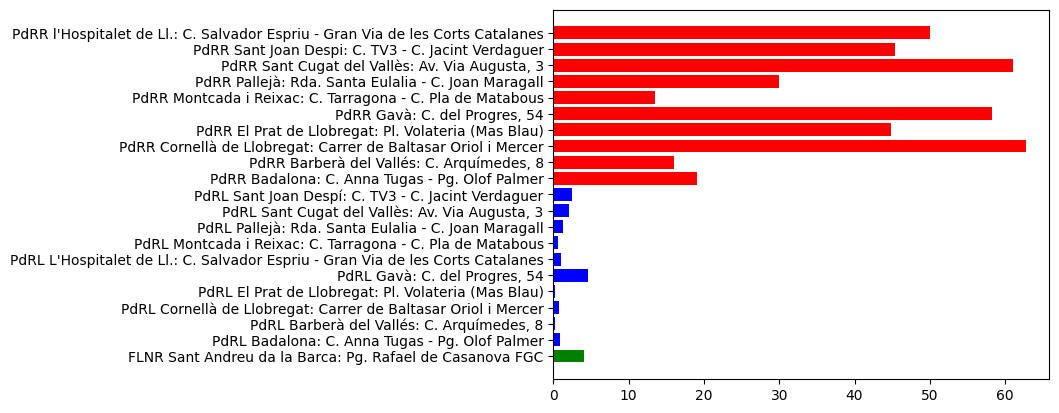

In [44]:
plt.barh(means.index, means.values, color=color)

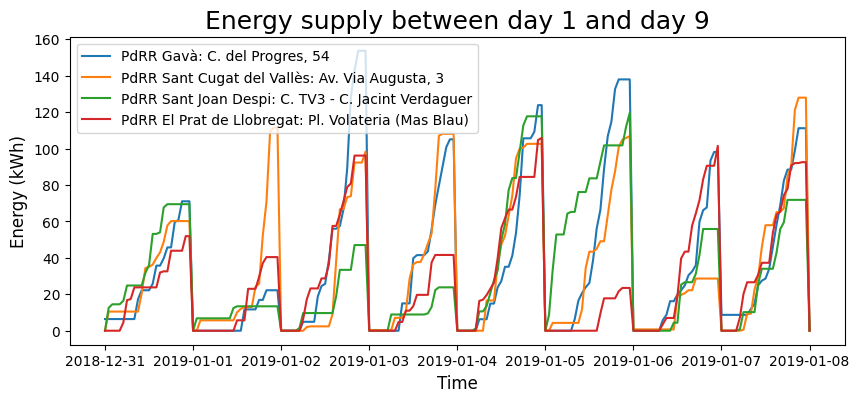

In [45]:
plotTimeInterval(Bcn_dayE_1h, Bcn_stations[0:4], days_start=1, days_end=9, ylabel='Energy (kWh)')

**IMPORTANTE**: Este nuevo dataset está en kWh, no en Wh

In [46]:
# Modificar para guardar
Bcn_dayE_1h_tosave = Bcn_dayE_1h.reset_index(inplace=False, names=['Time'])
Bcn_dayE_1h_tosave.head(3)

,Time,"Power_PdRR Gavà: C. del Progres, 54","Power_PdRR Sant Cugat del Vallès: Av. Via Augusta, 3",Power_PdRR Sant Joan Despi: C. TV3 - C. Jacint Verdaguer,Power_PdRR El Prat de Llobregat: Pl. Volateria (Mas Blau),Power_PdRR Pallejà: Rda. Santa Eulalia - C. Joan Maragall,"Power_PdRR Barberà del Vallés: C. Arquímedes, 8",Power_PdRR l'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes,Power_PdRL Sant Joan Despí: C. TV3 - C. Jacint Verdaguer,Power_PdRR Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer,...,Power_PdRL Badalona: C. Anna Tugas - Pg. Olof Palmer,Power_PdRR Montcada i Reixac: C. Tarragona - C. Pla de Matabous,Power_PdRL Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer,"Power_PdRL Gavà: C. del Progres, 54",Power_PdRL Montcada i Reixac: C. Tarragona - C. Pla de Matabous,Power_PdRL L'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes,"Power_PdRL Sant Cugat del Vallès: Av. Via Augusta, 3",Power_PdRL El Prat de Llobregat: Pl. Volateria (Mas Blau),"Power_PdRL Barberà del Vallés: C. Arquímedes, 8",Power_FLNR Sant Andreu da la Barca: Pg. Rafael de Casanova FGC
0,2018-12-31 00:00:00,6.40101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-12-31 01:00:00,6.40101,10.50732,12.5736,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-12-31 02:00:00,6.40101,10.50732,14.51606,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
Bcn_dayE_1h_tosave.to_csv("Bcn_dayE_1h.csv", index=False)

## Agrupamos por intervalos de 1d

In [48]:
# Agrupación
Bcn_1d = Bcn_cont.groupby(pd.Grouper(freq='1D')).sum()

In [49]:
Bcn_1d

,"Power_PdRR Gavà: C. del Progres, 54","Power_PdRR Sant Cugat del Vallès: Av. Via Augusta, 3",Power_PdRR Sant Joan Despi: C. TV3 - C. Jacint Verdaguer,Power_PdRR El Prat de Llobregat: Pl. Volateria (Mas Blau),Power_PdRR Pallejà: Rda. Santa Eulalia - C. Joan Maragall,"Power_PdRR Barberà del Vallés: C. Arquímedes, 8",Power_PdRR l'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes,Power_PdRL Sant Joan Despí: C. TV3 - C. Jacint Verdaguer,Power_PdRR Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer,Power_PdRR Badalona: C. Anna Tugas - Pg. Olof Palmer,...,Power_PdRL Badalona: C. Anna Tugas - Pg. Olof Palmer,Power_PdRR Montcada i Reixac: C. Tarragona - C. Pla de Matabous,Power_PdRL Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer,"Power_PdRL Gavà: C. del Progres, 54",Power_PdRL Montcada i Reixac: C. Tarragona - C. Pla de Matabous,Power_PdRL L'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes,"Power_PdRL Sant Cugat del Vallès: Av. Via Augusta, 3",Power_PdRL El Prat de Llobregat: Pl. Volateria (Mas Blau),"Power_PdRL Barberà del Vallés: C. Arquímedes, 8",Power_FLNR Sant Andreu da la Barca: Pg. Rafael de Casanova FGC
2018-12-31,71065.39,60193.40,69476.40,51921.12,59651.68,98844.81,102862.11,3288.08,49227.31,82880.28,...,2808.40,36218.01,3881.69,3126.54,0.00,0.00,0.00,0.0,0.00,0.00
2019-01-01,22223.70,111509.07,13411.40,40426.53,10411.18,36302.67,29208.19,63.60,65239.23,50541.94,...,0.00,27627.55,108.20,0.00,0.00,0.00,0.00,0.0,0.00,0.00
2019-01-02,153738.93,98366.14,47037.91,96161.73,77663.73,92321.45,79841.82,2773.35,86354.91,75041.65,...,6086.29,8105.00,2970.46,7536.01,39.13,0.00,0.00,0.0,0.00,0.00
2019-01-03,105101.39,108102.19,23821.28,41594.33,24224.46,108067.80,82011.53,6765.96,71419.06,52434.05,...,6293.94,32918.29,8729.67,5707.20,1673.21,9203.36,0.00,0.0,0.00,0.00
2019-01-04,123857.38,102608.22,117722.84,105864.94,83968.46,68248.97,59930.00,2835.07,93577.33,68362.09,...,4334.96,17706.96,0.00,25409.89,1142.96,1208.93,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,276271.91,195795.74,127185.96,174453.92,54633.47,47053.51,229249.26,3367.66,228675.92,0.00,...,3689.83,63523.61,2383.13,6261.34,7317.45,0.00,0.00,0.0,0.00,57600.22
2019-12-28,184276.34,110957.47,98871.87,91763.17,140682.59,21915.55,122770.81,2448.00,106554.63,0.00,...,1368.60,13109.73,747.15,6539.08,0.00,1394.53,0.00,0.0,0.00,12960.00
2019-12-29,187335.98,211044.49,82348.72,140455.81,87558.53,10421.36,116186.76,44271.79,61634.82,0.00,...,0.00,13416.27,0.00,3192.38,0.00,0.00,1246.20,0.0,0.00,15191.32
2019-12-30,180570.56,171162.57,168399.95,187599.01,60137.10,13628.29,242938.24,10587.83,148374.08,0.00,...,0.00,83426.13,4592.54,28374.43,5491.72,0.00,130.51,0.0,0.00,7501.20


In [50]:
# Comprobación de que se ha hecho bien la agrupación
prueba_col = 'Power_'+Bcn_stations[0]
print(f"Suma en el dataset por sec: {sum(Bcn_cont[prueba_col])}, suma en el dataset por periodos: {sum(Bcn_1d[prueba_col])}")
print(f"Tamaño del dataset por sec: {len(Bcn_cont)}, dividido entre {24*3600} debería dar: {len(Bcn_cont)/(24*3600)}")
print(f"Tamaño del dataset por periodo: {len(Bcn_1d)}")

Suma en el dataset por sec: 53960666.079915926, suma en el dataset por periodos: 53960666.08000002
Tamaño del dataset por sec: 31616581, dividido entre 86400 debería dar: 365.93265046296295
Tamaño del dataset por periodo: 366


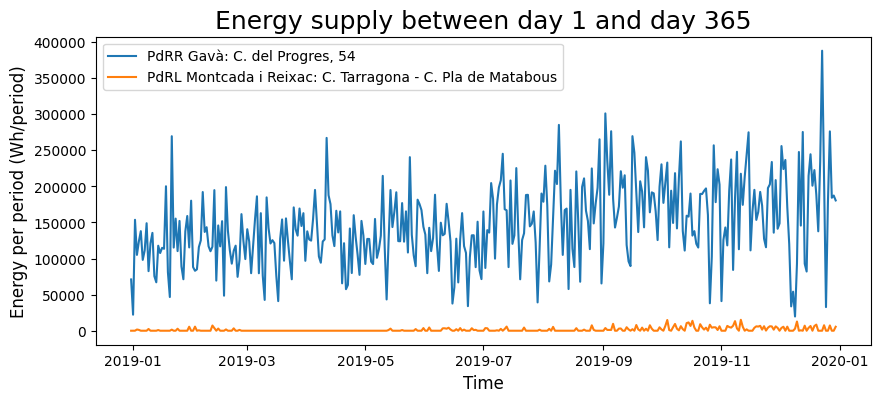

In [51]:
plotTimeInterval(Bcn_1d, Bcn_stations[[0,15]], days_start=1, days_end=365)

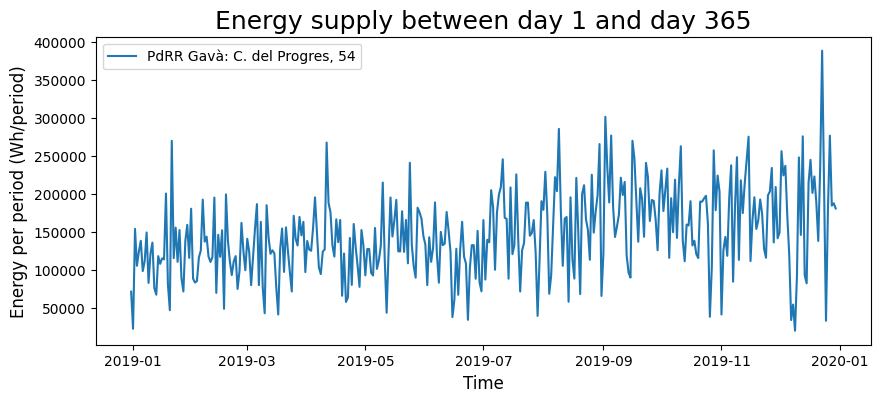

In [75]:
plotTimeInterval(Bcn_1d, Bcn_stations[0:1], days_start=1, days_end=365)

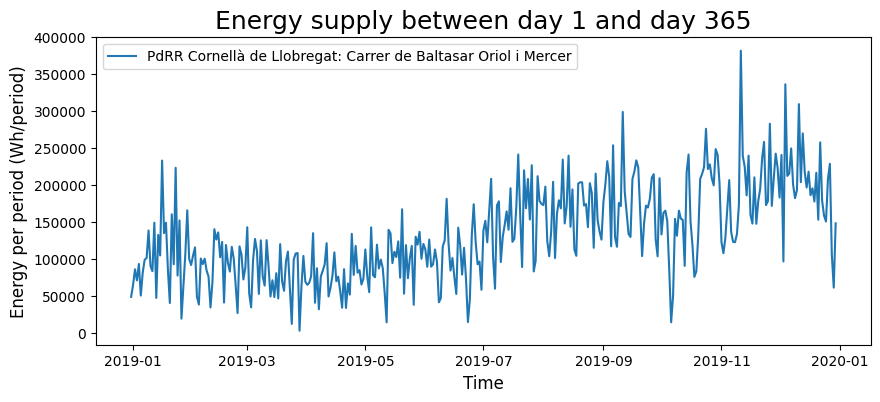

In [76]:
plotTimeInterval(Bcn_1d, ['PdRR Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer'], days_start=1, days_end=365)

## Guardamos dataset agrupado
Volvemos a poner el tiempo como columna para que sea más facilmente legible

In [53]:
# Modificar para guardar
Bcn_1d_tosave = Bcn_1d.reset_index(inplace=False, names=['Time'])
Bcn_1d_tosave.head(3)

,Time,"Power_PdRR Gavà: C. del Progres, 54","Power_PdRR Sant Cugat del Vallès: Av. Via Augusta, 3",Power_PdRR Sant Joan Despi: C. TV3 - C. Jacint Verdaguer,Power_PdRR El Prat de Llobregat: Pl. Volateria (Mas Blau),Power_PdRR Pallejà: Rda. Santa Eulalia - C. Joan Maragall,"Power_PdRR Barberà del Vallés: C. Arquímedes, 8",Power_PdRR l'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes,Power_PdRL Sant Joan Despí: C. TV3 - C. Jacint Verdaguer,Power_PdRR Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer,...,Power_PdRL Badalona: C. Anna Tugas - Pg. Olof Palmer,Power_PdRR Montcada i Reixac: C. Tarragona - C. Pla de Matabous,Power_PdRL Cornellà de Llobregat: Carrer de Baltasar Oriol i Mercer,"Power_PdRL Gavà: C. del Progres, 54",Power_PdRL Montcada i Reixac: C. Tarragona - C. Pla de Matabous,Power_PdRL L'Hospitalet de Ll.: C. Salvador Espriu - Gran Via de les Corts Catalanes,"Power_PdRL Sant Cugat del Vallès: Av. Via Augusta, 3",Power_PdRL El Prat de Llobregat: Pl. Volateria (Mas Blau),"Power_PdRL Barberà del Vallés: C. Arquímedes, 8",Power_FLNR Sant Andreu da la Barca: Pg. Rafael de Casanova FGC
0,2018-12-31,71065.39,60193.40,69476.40,51921.12,59651.68,98844.81,102862.11,3288.08,49227.31,...,2808.40,36218.01,3881.69,3126.54,0.00,0.0,0.0,0.0,0.0,0.0
1,2019-01-01,22223.70,111509.07,13411.40,40426.53,10411.18,36302.67,29208.19,63.60,65239.23,...,0.00,27627.55,108.20,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2,2019-01-02,153738.93,98366.14,47037.91,96161.73,77663.73,92321.45,79841.82,2773.35,86354.91,...,6086.29,8105.00,2970.46,7536.01,39.13,0.0,0.0,0.0,0.0,0.0


In [54]:
Bcn_1d_tosave.to_csv("./Bcn_1d.csv", index=False)

In [66]:
def plot_bar(df, station):
    plt.figure(figsize=(12,4))
    plt.bar(x=Bcn_1d.index, height=Bcn_1d[station])
    plt.title(f'Consumo diario: {station}', size=18)
    plt.ylabel('kWh/día', size=12)
    plt.xlabel('Fecha', size=12)
    plt.show()

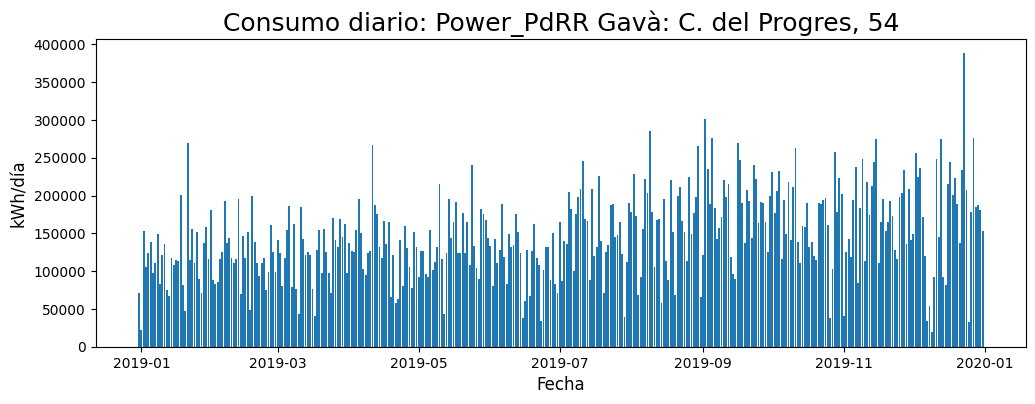

In [67]:
plot_bar(Bcn_1d, 'Power_PdRR Gavà: C. del Progres, 54')